# **Mounting Google Drive**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Import necessary library and read data from dataset**

In [2]:
#import necessary library needed
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

#read data from google drive
movie_reviews = pd.read_csv("/content/gdrive/Shared drives/Natural Language Processing/IMDB Dataset.csv")

#check if there is any null value
movie_reviews.isnull().values.any()

#to know the size of the dataset
movie_reviews.shape

(50000, 2)

In [3]:
#print a few example of the dataset
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

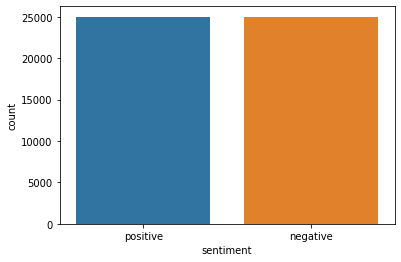

In [5]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)
#plot out all data into postive and negative categories, it is quite balance, not biased to any category

# **Data preprocessing**


In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
X[3]
#print same sample, and this is different that the one above since all unwanted html tags are removed

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [10]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [11]:
#separate the data with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [12]:
#building a word to index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
#set the maximum length of each list as 100, more than that will truncate, less than 100 will perform padding with 0

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/gdrive/Shared drives/Natural Language Processing/glove.6B.100d.txt', encoding="utf8")
#glove is machine learning algorithm that use vector to represent word and this text file contains those words and its vector value
#we want to create a dictionary that will contain words as keys and their corresponding embedding list as values. 

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#create an embedding matrix where each row number will correspond to the index of the word in the corpus

# **Build Neural Network Layer**


In [16]:
#Simple Neural Network Layer
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 3s 5ms/step - loss: 0.6574 - acc: 0.6214 - val_loss: 0.5423 - val_acc: 0.7256
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4928 - acc: 0.7657 - val_loss: 0.5215 - val_acc: 0.7426
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4500 - acc: 0.7910 - val_loss: 0.5216 - val_acc: 0.7419
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4272 - acc: 0.8082 - val_loss: 0.5196 - val_acc: 0.7467
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4113 - acc: 0.8140 - val_loss: 0.5342 - val_acc: 0.7380
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3931 - acc: 0.8236 - val_loss: 0.5327 - val_acc: 0.7416


In [19]:
score = model.evaluate(X_test, y_test, verbose=1)


313/313 [==============================] - 1s 2ms/step - loss: 0.5349 - acc: 0.7408


In [20]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5349116325378418
Test Accuracy: 0.7408000230789185


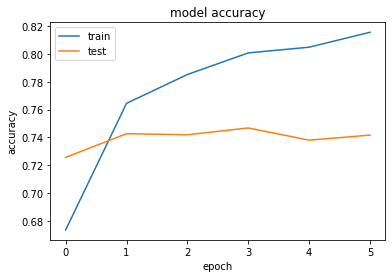

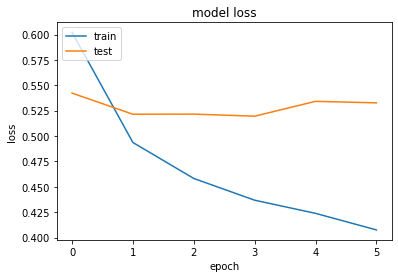

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# **Making prediction of an instance**


In [22]:
instance = X[60]
print(instance)

What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 


In [23]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.99970824]], dtype=float32)

In [24]:
movie_reviews["review"][60]

'What happened? What we have here is basically a solid and plausible premise and with a decent and talented cast, but somewhere the movie loses it. Actually, it never really got going. There was a little excitement when we find out that Angie is not really pregnant, then find out that she is after all, but that was it. Steve Martin, who is a very talented person and usually brings a lot to a movie, was dreadful and his entire character was not even close to being important to this movie, other than to make it longer. I really would have liked to see more interactions between the main characters, Kate and Angie, and maybe try not for a pure comedy, which unfortunately it was not, but maybe a drama with comedic elements. I think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here I can think of numerous scenarios that would have been a riot.'

In [25]:
movie_reviews["sentiment"][60]

'negative'